In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16 import VGG16
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#read the image
# function to load the dataset and return the dataset list
# containing elements of format [scans, target]
targets = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(scans):
    data = list()
    for target in targets: 
        path = os.path.join(scans, target)
        class_label = targets.index(target)
        for img in os.listdir(path):
            try:
                arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(arr, (img_size, img_size))
                data.append([resized_arr, class_label])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
#extracting the dataset
train = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/train')
test = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/test')
val = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/val')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
#split the data into training, testing and validation groups with variables to hold the target names.
images = []
labels = []

for image_scan, target in train:
    images.append(image_scan)
    labels.append(target)

for image_scan, target in test:
    images.append(image_scan)
    labels.append(target)

for image_scan, target in val:
    images.append(image_scan)
    labels.append(target)



In [6]:
# Normalize data
images = np.array(images) / 255

In [7]:
# resize data
images = images.reshape(-1, img_size, img_size, 3)
labels = np.array(labels)

In [8]:
#prevents overfitting and handles the imbalance in dataset

data_aug = ImageDataGenerator(
        rotation_range = 30,  #rotate 
        zoom_range = 0.2, #  zoom  
        width_shift_range=0.1,  #  shift images horizontally 
        height_shift_range=0.1,  #  shift images vertically
        horizontal_flip = True,  # flip images
        vertical_flip=False)  # no vertical flip

data_aug.fit(images)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.30, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.30, shuffle=True)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4099, 150, 150, 3)
(1229, 150, 150, 3)
(528, 150, 150, 3)


In [11]:
print(X_train.shape[1:])

(150, 150, 3)


58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

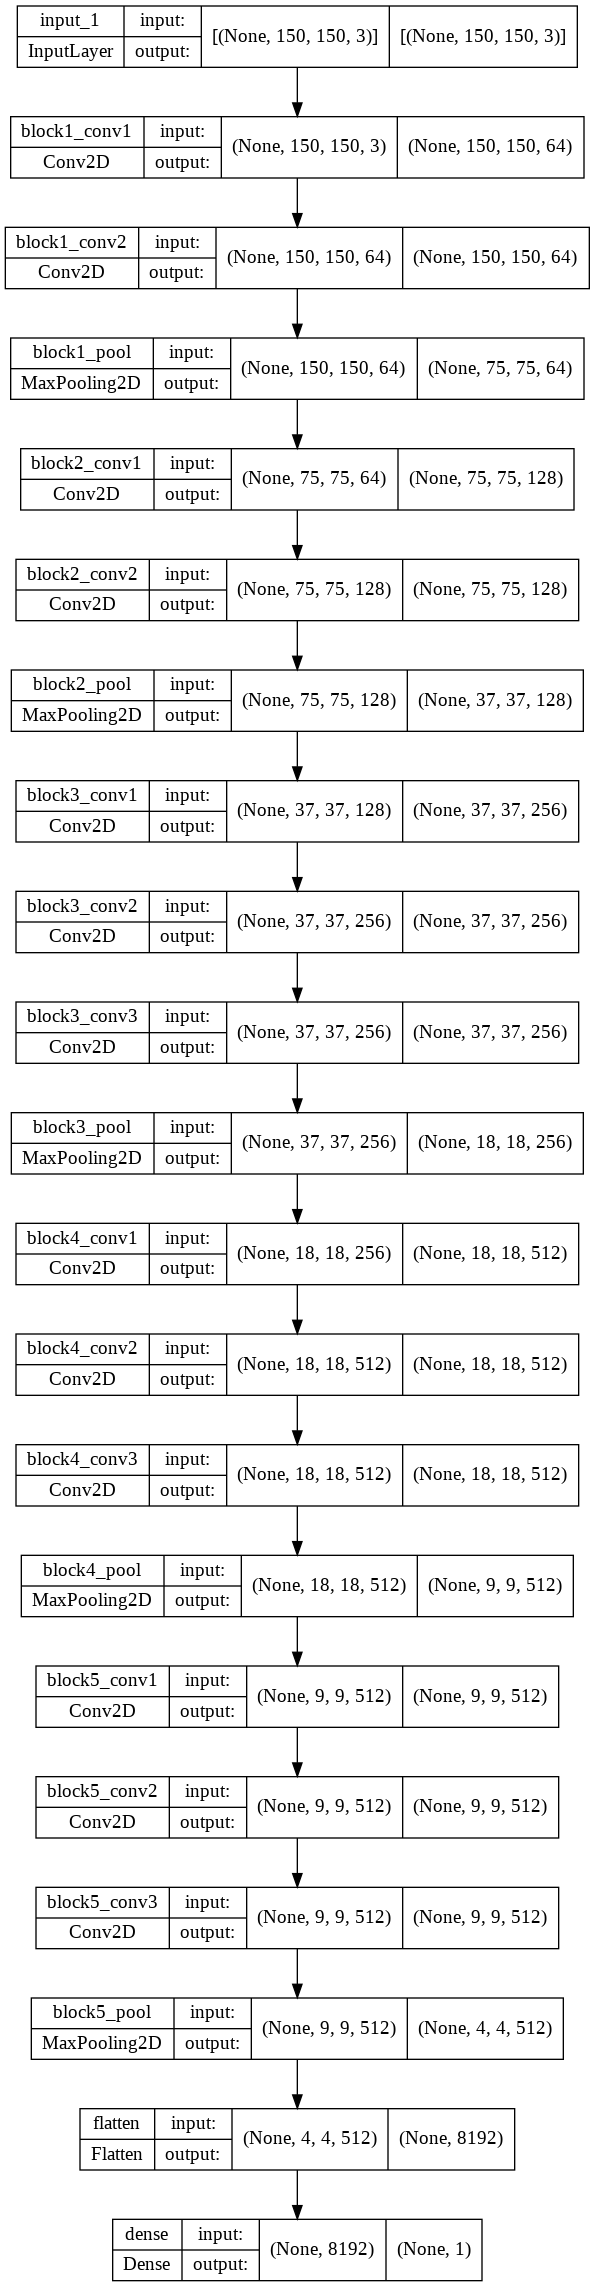

In [12]:
#building the model
IMAGE_SIZE = X_train.shape[1:]

vgg = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

# freezing restNet layers
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)

output_layer = Dense(1, activation='sigmoid')(x)

# creating early stopping.
es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
# creating model checkpoint
mc = ModelCheckpoint("VggModel.h5", monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# creating class weights
#cw = {0: 1.0, 1: 1.0}

vgg_model = Model(inputs=vgg.input, outputs=output_layer)

vgg_model.summary()

plot_model(vgg_model, to_file = 'modelVgg_plot.png', show_shapes = True, show_layer_names = True)

In [13]:
# compile model
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# fitting the model
history = vgg_model.fit(data_aug.flow(X_train, y_train), batch_size = 128, epochs=50, validation_data=(X_test, y_test), callbacks = [es,mc],verbose=1)#,class_weight=cw)

Epoch 1/50
129/129 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8717
Epoch 1: val_loss improved from inf to 0.28938, saving model to VggModel.h5
129/129 [==============================] - 49s 276ms/step - loss: 0.3195 - accuracy: 0.8717 - val_loss: 0.2894 - val_accuracy: 0.8747
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9156
Epoch 2: val_loss improved from 0.28938 to 0.21872, saving model to VggModel.h5
129/129 [==============================] - 25s 196ms/step - loss: 0.2174 - accuracy: 0.9156 - val_loss: 0.2187 - val_accuracy: 0.9081
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9222
Epoch 3: val_loss did not improve from 0.21872
129/129 [==============================] - 25s 194ms/step - loss: 0.1988 - accuracy: 0.9222 - val_loss: 0.2554 - val_accuracy: 0.8885
Epoch 4/50
129/129 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9219
Epoch 4: va

In [15]:
vgg_model.save('PNmodelVgg.h5')

In [16]:
vgg_model.evaluate(X_val,y_val)

17/17 [==============================] - 2s 145ms/step - loss: 0.1364 - accuracy: 0.9470


[0.1363506019115448, 0.9469696879386902]

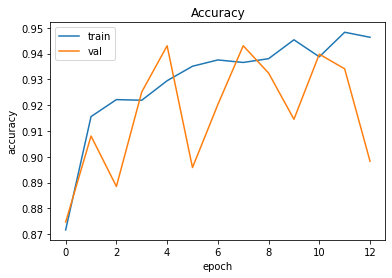

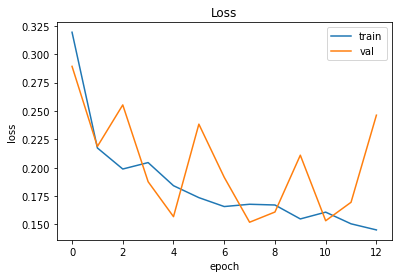

In [17]:
#plotting the data to demonstrate the accuracy of the train and validations. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

#plotting the data to demonstrate the loss of the train and validations. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()